In [1]:
train_path = "../../data/train_preprocessed.json"
test_path = "../../data/test.json"

In [36]:
import sys
sys.path.append('../')
from utils import read_dataset
import tensorflow as tf
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, Concatenate
from tensorflow.keras import Input, Model
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall
import seaborn as sns

In [3]:
inputs_train, y_train, inputs_test, y_test, user_max, book_max = read_dataset(train_path, test_path, only_mlp=True, balance_test=True)

In [22]:
print(f"Train set: {y_train.sum()/y_train.shape[0]:.4f}")
print(f"Test set : {y_test.sum()/y_test.shape[0]:.4f}")

Train set: 0.3936
Test set : 0.3948


In [7]:
def MLP_model(user_max, book_max, user_emb_size=12, book_emb_size=12):
    user_id_input = Input(shape=(1,), name="user_id")
    book_id_input = Input(shape=(1,), name="book_id")
    numerics_input = Input(shape=(3,), name="numerics")

    user_embedding = Embedding(input_dim=user_max + 3, output_dim=user_emb_size, input_length=1, name="user_embedding")(user_id_input)
    book_embedding = Embedding(input_dim=book_max + 3, output_dim=book_emb_size, input_length=1, name="book_embedding")(book_id_input)

    user_flattened = Flatten()(user_embedding)
    book_flattened = Flatten()(book_embedding)

    numerics = Sequential([
        Dense(40, activation="relu"),
        BatchNormalization(),
        Dropout(0.5)
    ])(numerics_input)

    concatenated = Concatenate()([user_flattened, book_flattened, numerics])

    out = BatchNormalization()(Dense(256, activation="relu")(concatenated))
    out = Dropout(0.5)(out)
    out = BatchNormalization()(Dense(64, activation="relu")(out))
    out = Dense(1, activation="sigmoid")(out)


    model = Model(inputs=[user_id_input, book_id_input, numerics_input], outputs=out)
    return model

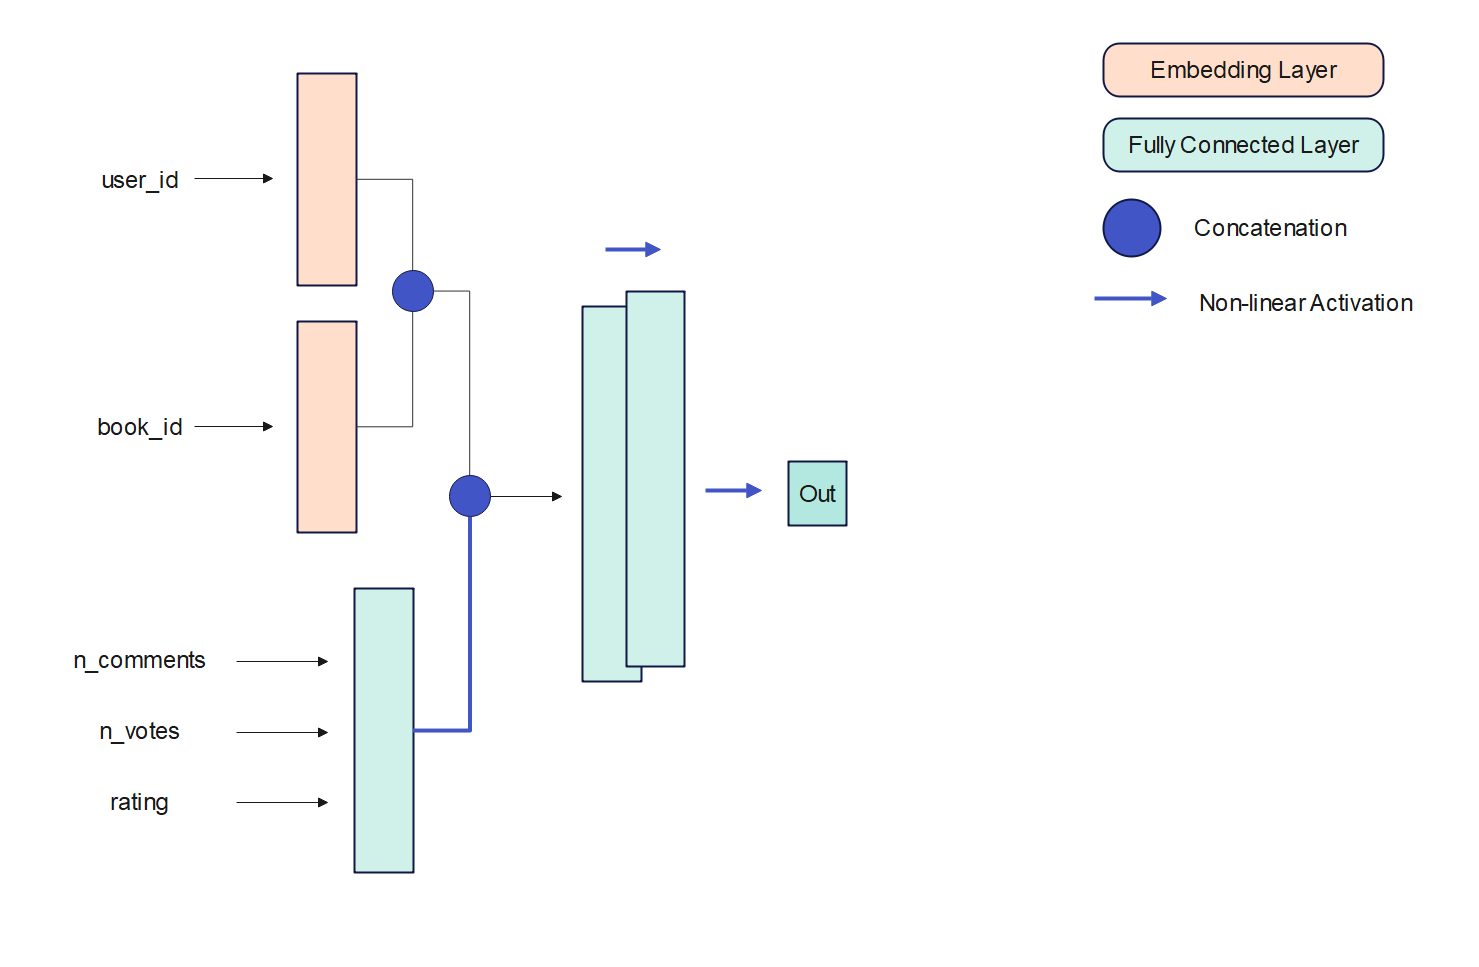

**Note:** In the code, we concatenated all feature at once, however this doesn't make any difference.

In [37]:
model = MLP_model(user_max, book_max, user_emb_size=24, book_emb_size=16)

# We used a simple learning rate scheduler, because it works well
def scheduler(epoch, lr=1e-4):
    if epoch < 4:
        return lr
    else:
        return 1e-6

lr_scheduler = LearningRateScheduler(scheduler)

In [38]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(), Precision(), Recall()])
model.fit(inputs_train, y_train, validation_split=0.2, epochs=6, batch_size=256,callbacks=[lr_scheduler])

Epoch 1/6
413/413 [==============================] - 4s 6ms/step - loss: 0.6869 - auc_2: 0.5431 - precision: 0.4364 - recall: 0.1596 - val_loss: 0.6577 - val_auc_2: 0.6372 - val_precision: 0.6069 - val_recall: 0.1458 - lr: 0.0010
Epoch 2/6
413/413 [==============================] - 2s 5ms/step - loss: 0.5973 - auc_2: 0.7159 - precision: 0.6357 - recall: 0.4214 - val_loss: 0.5591 - val_auc_2: 0.7651 - val_precision: 0.6596 - val_recall: 0.5492 - lr: 0.0010
Epoch 3/6
413/413 [==============================] - 2s 5ms/step - loss: 0.5247 - auc_2: 0.8033 - precision: 0.6958 - recall: 0.6111 - val_loss: 0.5547 - val_auc_2: 0.7728 - val_precision: 0.6399 - val_recall: 0.6122 - lr: 0.0010
Epoch 4/6
413/413 [==============================] - 2s 5ms/step - loss: 0.4988 - auc_2: 0.8259 - precision: 0.7154 - recall: 0.6636 - val_loss: 0.5592 - val_auc_2: 0.7727 - val_precision: 0.6654 - val_recall: 0.5634 - lr: 0.0010
Epoch 5/6
413/413 [==============================] - 2s 5ms/step - loss: 0.4740 

In [39]:
preds = model.predict(inputs_test, batch_size=512, verbose=0)

# selects best threshold value
thresholds = np.linspace(0,0.5,100)
best = 0
best_th = None
for th in thresholds:
    f1 = f1_score(y_test, (preds>th).astype(int))
    if f1 > best:
        best = f1
        best_th = th
        
binary_preds = (preds > best_th).astype(int)
print(f"threshold: {best_th}")
print(f"Precision: {precision_score(binary_preds, y_test)}")
print(f"Recall:    {recall_score(binary_preds, y_test)}")
print(f"F1 score:  {best}")
print(f"AUC score: {roc_auc_score(binary_preds, y_test)}")

threshold: 0.297979797979798
Precision: 0.8003985896060095
Recall:    0.5533651298357181
F1 score:  0.6543426494548189
AUC score: 0.6848371924573624


In [40]:
model.evaluate(inputs_test, y_test)

1033/1033 [==============================] - 1s 1ms/step - loss: 0.5646 - auc_2: 0.7655 - precision: 0.6375 - recall: 0.6008


[0.5646001696586609, 0.7655032277107239, 0.6374949216842651, 0.600797176361084]

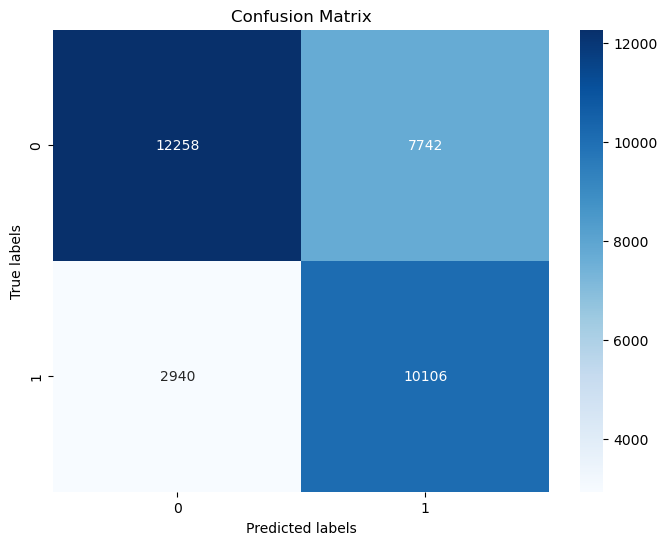

In [19]:
# Getting the confusion matrix
conf_matrix = confusion_matrix(y_test, (preds>best_th).astype(int))

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
model.save_weights("../pretrained_models/mlp_model.h5")

In [25]:
y_train.sum(), y_train.shape

(51925, (131925,))

In [26]:
a = model.evaluate(inputs_test, y_test)

1033/1033 [==============================] - 1s 998us/step - loss: 0.5637 - auc: 0.7654


In [27]:
a

[0.5636820197105408, 0.7654472589492798]

In [29]:
y_test.sum(), y_test.shape

(13046, (33046,))